In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch_optimizer as optim
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time

from model import ConvNet_Shallow_Single as ConvNet_SS
from model import ConvNet 


import sys

import fasttext.CustomDataset as CustomDataset

[nltk_data] Downloading package punkt to /nfs4/ushashi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))
        

LEARNINGRATE = 9e-2
GAMMA = 0.94

BATCHSIZE = 1024
NUMEPOCHS = 20


dset = CustomDataset.get_dataset('data/train.csv')
tset = CustomDataset.get_dataset('data/test.csv')

print('''
0 - World
1 - Sports
2 - Business
3 - Sci/Tech
''')

### TRAIN VAL SPLIT

NUM_DATA_POINTS = len(dset)

indices = list(range(NUM_DATA_POINTS))
split = int(np.floor(0.2 * NUM_DATA_POINTS))
np.random.shuffle(indices)

print(indices[0])


train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_points = len(train_indices)
val_points = len(val_indices)

train_loader = torch.utils.data.DataLoader(dset, batch_size = BATCHSIZE, 
                                           sampler=train_sampler, num_workers=4)
validation_loader = torch.utils.data.DataLoader(dset, batch_size = BATCHSIZE,
                                                sampler=valid_sampler, num_workers=4)
test_loader = torch.utils.data.DataLoader(tset, batch_size = BATCHSIZE,
                                                num_workers=4)

print("Printing Train + Val Number of Documents Found")
print(NUM_DATA_POINTS)

/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/nfs4/ushashi/anaconda3/envs/gp


0 - World
1 - Sports
2 - Business
3 - Sci/Tech

23848
Printing Train + Val Number of Documents Found
120000


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ConvNet(True, WINDOW=3)
print('Running on',device)
print('Building Master model..')
model.to(device)
print('Model Built.')

FILE = 'fasttext/weights_2/Model_quicksave5.pt'

model.load_state_dict(torch.load(FILE,map_location='cuda:0'))
model.eval()

print('Initializing optimizer and scheduler..')

criterion = torch.nn.NLLLoss()
optimizer = optim.RAdam(model.parameters(), lr = LEARNINGRATE)             # OR RAdam/DiffGrad/etc
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = GAMMA)

print('Optimizer and scheduler initialized.')


print('Printing Parameters')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
        #print(param.shape)
print('---Printing Parameters Finished!---')

Running on cuda:0
Building Master model..
Model Built.
Initializing optimizer and scheduler..
Optimizer and scheduler initialized.
Printing Parameters
conv1.weight
conv1.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
---Printing Parameters Finished!---


In [4]:
corr = 0.0
with torch.no_grad():
  for ib,sample in enumerate(test_loader):

    data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
    data_output = torch.as_tensor(sample['class'][:,0])

    data_input = data_input.to(device, dtype=torch.float)
    data_output = data_output.to(device, dtype=torch.long)

    output = model(data_input)
    _, preds = torch.max(output,dim=1)
    corr += (torch.sum(preds == data_output.data)).data.item()

print('Test Accuracy : {:.2f}%'.format(corr*100.0/len(tset)))

Test Accuracy : 91.12%


In [5]:
from keras import backend as K
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Conv2D, Input, Dense, MaxPool2D, Flatten, Lambda, GlobalMaxPool2D, Dropout
from keras.models import Model
import tensorflow as tf
import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.utils.tests.networks import base as network_base

print(K.image_data_format())

with tf.device('/GPU:0'):
    inp = Input((None,300,1))
    x = Conv2D(1024,(3,300),activation='relu', name='conv1')(inp)
    x = GlobalMaxPool2D('channels_last')(x)
    x = Dense(256,name='fc1',activation='relu')(x)
    z = Dropout(0.25)(x)
    ou = Dense(32,name='fc2',activation='relu')(z)
    ou = Dropout(0.3)(ou)
    out = Dense(4,name='fc3')(ou)
    outz = Dropout(0.2)(out)
    k_model = Model(inp, outz)


trained_weights = model.state_dict()

pytorch_layers = [] # get ptroch layers names and suffixes
for x, l in zip(trained_weights, k_model.layers):
    pytorch_layers.append(x[:x.find('.')])

unique_layers = np.unique(pytorch_layers)
print(unique_layers)


for layer in unique_layers:
    weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
    biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
    if 'bn' in layer:
        running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
        running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
        W = [weights, biases, running_mean, running_var]
    elif 'fc' in layer:
        biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
        W = [weights.T, biases]
    else:
        W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
    k_model.get_layer(layer).set_weights(W)

k_model.summary()

channels_last
['conv1' 'fc1' 'fc2' 'fc3']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 300, 1)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, 1, 1024)     922624    
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1024)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 32)                8224      
_________________________________________________________________
dropout_2 (Dropout)          (None

In [6]:
method = ("lrp.z",{},"LRP-Z")
         
analyzer = innvestigate.create_analyzer(method[0], k_model,neuron_selection_mode="index",**method[1]) #neuron_selection_mode="index",  

'''
for i in range(train_points):
 
    index = train_indices[i]
    x = dset[index]['matrix']
    x = x.reshape((1, -1, 300,1)).numpy()    
    analyzis[i] = np.zeros(x.shape[1])
    
    a = np.squeeze(analyzer.analyze(x))
    a = np.sum(a, axis=1)
    analyzis[i] = a   
'''

"\nfor i in range(train_points):\n \n    index = train_indices[i]\n    x = dset[index]['matrix']\n    x = x.reshape((1, -1, 300,1)).numpy()    \n    analyzis[i] = np.zeros(x.shape[1])\n    \n    a = np.squeeze(analyzer.analyze(x))\n    a = np.sum(a, axis=1)\n    analyzis[i] = a   \n"

In [7]:
import time

top_n = 5
min_val_loss = float('inf')

loss_values_train = []
loss_values_val = []

print('Batch Size = ',BATCHSIZE)

for epoch in range(1,NUMEPOCHS+1):
    start_time = time.time()
    
    model.train()
    runloss = 0.0
    tacc = 0
    ##################
    #print('At start')
    #time.sleep(10)
    if epoch%2 == 1:
        mode = 'Forced Epoch'
        
        for layer in unique_layers:
            weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
            biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
            if 'bn' in layer:
                running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
                running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
                W = [weights, biases, running_mean, running_var]
            elif 'fc' in layer:
                biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
                W = [weights.T, biases]
            else:
                W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
            k_model.get_layer(layer).set_weights(W)
        
        ############
        #print('After model load')
        #time.sleep(10)
        for ib,sample in enumerate(train_loader):
            
            data_input = sample['matrix'][:,None,:,:].numpy()
            data_output = sample['class'][:,0].numpy()

            for j in range(BATCHSIZE):
                #index = train_indices[BATCHSIZE*ib+j]
                #sample = dset[index]
                try:
                    data = data_input[j]
                except IndexError as error:
                    break
                
                data = data.reshape((1, -1, 300,1))    
                analysis = np.zeros(data.shape[1])
                
                a = np.squeeze(analyzer.analyze(data,neuron_selection=data_output[j]))
                a = np.sum(a, axis=1)
                
                order = np.argsort(a)[::-1]
                for k in order[top_n:]:
                    data_input[j,:,k,:] = np.zeros((1,1,300)) 
            
            data_input = torch.as_tensor(data_input)
            data_output = torch.as_tensor(data_output)
            
            data_input = data_input.to(device, dtype=torch.float)  #, dtype=torch.float
            data_output = data_output.to(device, dtype=torch.long)    #, dtype=torch.long

            output = model(data_input) 
            _, preds = torch.max(output, 1)

            loss = criterion(output, data_output)
            runloss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            runloss += loss.item() * data_input.size(0)
            tacc += (torch.sum(preds == data_output.data)).data.item()

        runloss /= (train_points)
        tacc = tacc*100.0/ (train_points)

        loss_values_train.append(runloss)
        
        
    if epoch%2 == 0:    
        mode = 'Unforced Epoch'
        for ib,sample in enumerate(train_loader):

            data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
            data_output = torch.as_tensor(sample['class'][:,0])

            data_input = data_input.to(device, dtype=torch.float)  #, dtype=torch.float
            data_output = data_output.to(device, dtype=torch.long)    #, dtype=torch.long

            output = model(data_input) 
            _, preds = torch.max(output, 1)

            loss = criterion(output, data_output)
            runloss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            runloss += loss.item() * data_input.size(0)
            tacc += (torch.sum(preds == data_output.data)).data.item()

        runloss /= train_points 
        tacc = tacc*100.0/ train_points

        loss_values_train.append(runloss)
    
    model.eval()

    val_loss = 0
    corr = 0
    
    with torch.no_grad():
        for ib,sample in enumerate(validation_loader):
            
            data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
            data_output = torch.as_tensor(sample['class'][:,0])

            data_input = data_input.to(device, dtype=torch.float)
            data_output = data_output.to(device, dtype=torch.long)

            output = model(data_input)
            _, preds = torch.max(output,dim=1)
            
            loss = criterion(output, data_output)
            val_loss += loss.item()* data_input.size(0)
            corr += (torch.sum(preds == data_output.data)).data.item()
            
    val_loss /= val_points
    corr = corr*100.0/val_points
    loss_values_val.append(val_loss)

    if val_loss <= min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'fasttext/feedback_POS/Model_best_val_quicksave.pt')

    
    stop_time = time.time()
    time_el = int(stop_time-start_time)
    

    print('epoch [{}/{}] '.format(epoch, NUMEPOCHS)+mode+' loss:{:.7f}, train acc:{:.4f}, val loss:{:.7f}, val acc:{:.4f} in {}h {}m {}s'.format(
                                                                                runloss, tacc, val_loss, corr,
                                                                                time_el//3600,
                                                                                (time_el%3600)//60,
                                                                               time_el%60))
    
    torch.save(model.state_dict(), 'fasttext/feedback_POS/Model_quicksave'+str(epoch)+'.pt')
    scheduler.step()
    

Batch Size =  1024
epoch [1/20] Forced Epoch loss:0.1954318, train acc:91.9344, val loss:0.6349125, val acc:80.3250 in 0h 3m 59s
epoch [2/20] Unforced Epoch loss:1.5850650, train acc:26.2271, val loss:1.3866769, val acc:24.8667 in 0h 0m 43s
epoch [3/20] Forced Epoch loss:1.3886599, train acc:24.7396, val loss:1.3865986, val acc:24.9167 in 0h 3m 58s
epoch [4/20] Unforced Epoch loss:1.3880080, train acc:25.0344, val loss:1.3863088, val acc:25.0917 in 0h 0m 44s
epoch [5/20] Forced Epoch loss:1.3886124, train acc:25.0542, val loss:1.3863903, val acc:25.1250 in 0h 4m 0s
epoch [6/20] Unforced Epoch loss:1.3897905, train acc:24.8167, val loss:1.3864269, val acc:25.1250 in 0h 0m 44s
epoch [7/20] Forced Epoch loss:1.3878485, train acc:24.9396, val loss:1.3863330, val acc:25.0917 in 0h 3m 59s
epoch [8/20] Unforced Epoch loss:1.3911532, train acc:25.0240, val loss:1.3868168, val acc:25.1250 in 0h 0m 44s
epoch [9/20] Forced Epoch loss:1.3879875, train acc:25.1177, val loss:1.3865719, val acc:24.91

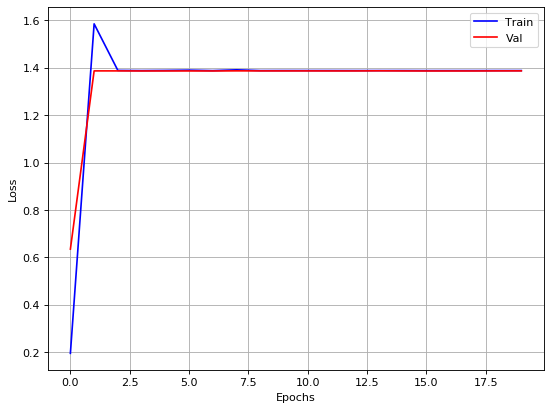

In [8]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.array(loss_values_train), 'b')
plt.plot(np.array(loss_values_val), 'r')
plt.legend(['Train','Val'])
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('fasttext/train_curve_feedback-v1_POS.png')
plt.show()

In [9]:
corr = 0.0
with torch.no_grad():
  for ib,sample in enumerate(test_loader):

    data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
    data_output = torch.as_tensor(sample['class'][:,0])

    data_input = data_input.to(device, dtype=torch.float)
    data_output = data_output.to(device, dtype=torch.long)

    output = model(data_input)
    _, preds = torch.max(output,dim=1)
    corr += (torch.sum(preds == data_output.data)).data.item()

print('Test Accuracy : {:.2f}%'.format(corr*100.0/len(tset)))

Test Accuracy : 25.00%


In [12]:
LEARNINGRATE = 5e-3
GAMMA = 0.9

BATCHSIZE = 1024
NUMEPOCHS = 20


dset = CustomDataset.get_dataset('data/train.csv')
tset = CustomDataset.get_dataset('data/test.csv')

print('''
0 - World
1 - Sports
2 - Business
3 - Sci/Tech
''')

### TRAIN VAL SPLIT

NUM_DATA_POINTS = len(dset)

indices = list(range(NUM_DATA_POINTS))
split = int(np.floor(0.2 * NUM_DATA_POINTS))
np.random.shuffle(indices)

print(indices[0])


train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_points = len(train_indices)
val_points = len(val_indices)

train_loader = torch.utils.data.DataLoader(dset, batch_size = BATCHSIZE, 
                                           sampler=train_sampler, num_workers=4)
validation_loader = torch.utils.data.DataLoader(dset, batch_size = BATCHSIZE,
                                                sampler=valid_sampler, num_workers=4)
test_loader = torch.utils.data.DataLoader(tset, batch_size = BATCHSIZE,
                                                num_workers=4)

print("Printing Train + Val Number of Documents Found")
print(NUM_DATA_POINTS)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ConvNet(True, WINDOW=3)
print('Running on',device)
print('Building Master model..')
model.to(device)
print('Model Built.')

FILE = 'fasttext/weights_2/Model_quicksave5.pt'

model.load_state_dict(torch.load(FILE,map_location='cuda:0'))
model.eval()

print('Initializing optimizer and scheduler..')

criterion = torch.nn.NLLLoss()
optimizer = optim.RAdam(model.parameters(), lr = LEARNINGRATE)             # OR RAdam/DiffGrad/etc
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = GAMMA)

print('Optimizer and scheduler initialized.')


print('Printing Parameters')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
        #print(param.shape)
print('---Printing Parameters Finished!---')

corr = 0.0
with torch.no_grad():
  for ib,sample in enumerate(test_loader):

    data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
    data_output = torch.as_tensor(sample['class'][:,0])

    data_input = data_input.to(device, dtype=torch.float)
    data_output = data_output.to(device, dtype=torch.long)

    output = model(data_input)
    _, preds = torch.max(output,dim=1)
    corr += (torch.sum(preds == data_output.data)).data.item()

print('Test Accuracy : {:.2f}%'.format(corr*100.0/len(tset)))


from keras import backend as K
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Conv2D, Input, Dense, MaxPool2D, Flatten, Lambda, GlobalMaxPool2D, Dropout
from keras.models import Model
import tensorflow as tf
import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.utils.tests.networks import base as network_base

print(K.image_data_format())

with tf.device('/GPU:0'):
    inp = Input((None,300,1))
    x = Conv2D(1024,(3,300),activation='relu', name='conv1')(inp)
    x = GlobalMaxPool2D('channels_last')(x)
    x = Dense(256,name='fc1',activation='relu')(x)
    z = Dropout(0.25)(x)
    ou = Dense(32,name='fc2',activation='relu')(z)
    ou = Dropout(0.3)(ou)
    out = Dense(4,name='fc3')(ou)
    outz = Dropout(0.2)(out)
    k_model = Model(inp, outz)


trained_weights = model.state_dict()

pytorch_layers = [] # get ptroch layers names and suffixes
for x, l in zip(trained_weights, k_model.layers):
    pytorch_layers.append(x[:x.find('.')])

unique_layers = np.unique(pytorch_layers)
print(unique_layers)


for layer in unique_layers:
    weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
    biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
    if 'bn' in layer:
        running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
        running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
        W = [weights, biases, running_mean, running_var]
    elif 'fc' in layer:
        biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
        W = [weights.T, biases]
    else:
        W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
    k_model.get_layer(layer).set_weights(W)

k_model.summary()

method = ("lrp.z",{},"LRP-Z")
         
analyzer = innvestigate.create_analyzer(method[0], k_model,neuron_selection_mode="index",**method[1])



0 - World
1 - Sports
2 - Business
3 - Sci/Tech

119909
Printing Train + Val Number of Documents Found
120000
Running on cuda:0
Building Master model..
Model Built.
Initializing optimizer and scheduler..
Optimizer and scheduler initialized.
Printing Parameters
conv1.weight
conv1.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
---Printing Parameters Finished!---
Test Accuracy : 91.12%
channels_last
['conv1' 'fc1' 'fc2' 'fc3']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, 300, 1)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, 1, 1024)     922624    
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 1024)              0         
_________________________________________________________________
fc1 (Dense)               

In [13]:
corr = 0.0
with torch.no_grad():
  for ib,sample in enumerate(test_loader):

    data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
    data_output = torch.as_tensor(sample['class'][:,0])

    data_input = data_input.to(device, dtype=torch.float)
    data_output = data_output.to(device, dtype=torch.long)

    output = model(data_input)
    _, preds = torch.max(output,dim=1)
    corr += (torch.sum(preds == data_output.data)).data.item()

print('Test Accuracy : {:.2f}%'.format(corr*100.0/len(tset)))

Test Accuracy : 91.12%


In [14]:
import time

NUMEPOCHS = 10
top_n = 7
min_val_loss = float('inf')

loss_values_train = []
loss_values_val = []

print('Batch Size = ',BATCHSIZE)

for epoch in range(1,NUMEPOCHS+1):
    start_time = time.time()
    
    model.train()
    runloss = 0.0
    tacc = 0
    ##################
    #print('At start')
    #time.sleep(10)
    mode = 'Forced Epoch'

    for layer in unique_layers:
        weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
        biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
        if 'bn' in layer:
            running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
            running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
            W = [weights, biases, running_mean, running_var]
        elif 'fc' in layer:
            biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
            W = [weights.T, biases]
        else:
            W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
        k_model.get_layer(layer).set_weights(W)

    ############
    #print('After model load')
    #time.sleep(10)
    for ib,sample in enumerate(train_loader):

        data_input = sample['matrix'][:,None,:,:].numpy()
        data_output = sample['class'][:,0].numpy()

        for j in range(BATCHSIZE):
            #index = train_indices[BATCHSIZE*ib+j]
            #sample = dset[index]
            try:
                data = data_input[j]
            except IndexError as error:
                break

            data = data.reshape((1, -1, 300,1))    
            analysis = np.zeros(data.shape[1])

            a = np.squeeze(analyzer.analyze(data,neuron_selection=data_output[j]))
            a = np.sum(a, axis=1)

            order = np.argsort(a)[::-1]
            for k in order[top_n:]:
                data_input[j,:,k,:] = np.zeros((1,1,300)) 

        data_input = torch.as_tensor(data_input)
        data_output = torch.as_tensor(data_output)

        data_input = data_input.to(device, dtype=torch.float)  #, dtype=torch.float
        data_output = data_output.to(device, dtype=torch.long)    #, dtype=torch.long

        output = model(data_input) 
        _, preds = torch.max(output, 1)

        loss = criterion(output, data_output)
        runloss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        runloss += loss.item() * data_input.size(0)
        tacc += (torch.sum(preds == data_output.data)).data.item()

    runloss /= (train_points)
    tacc = tacc*100.0/ (train_points)

    loss_values_train.append(runloss)


    model.eval()

    val_loss = 0
    corr = 0
    
    with torch.no_grad():
        for ib,sample in enumerate(validation_loader):
            
            data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
            data_output = torch.as_tensor(sample['class'][:,0])

            data_input = data_input.to(device, dtype=torch.float)
            data_output = data_output.to(device, dtype=torch.long)

            output = model(data_input)
            _, preds = torch.max(output,dim=1)
            
            loss = criterion(output, data_output)
            val_loss += loss.item()* data_input.size(0)
            corr += (torch.sum(preds == data_output.data)).data.item()
            
    val_loss /= val_points
    corr = corr*100.0/val_points
    loss_values_val.append(val_loss)

    if val_loss <= min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'fasttext/feedback-v2_POS/Model_best_val_quicksave.pt')

    
    stop_time = time.time()
    time_el = int(stop_time-start_time)
    

    print('epoch [{}/{}] '.format(epoch, NUMEPOCHS)+mode+' loss:{:.7f}, train acc:{:.4f}, val loss:{:.7f}, val acc:{:.4f} in {}h {}m {}s'.format(
                                                                                runloss, tacc, val_loss, corr,
                                                                                time_el//3600,
                                                                                (time_el%3600)//60,
                                                                               time_el%60))
    
    torch.save(model.state_dict(), 'fasttext/feedback-v2_POS/Model_quicksave'+str(epoch)+'.pt')
    scheduler.step()
    

Batch Size =  1024
epoch [1/10] Forced Epoch loss:0.1228521, train acc:93.5969, val loss:0.3572898, val acc:87.8208 in 0h 4m 2s
epoch [2/10] Forced Epoch loss:0.1063987, train acc:94.0229, val loss:0.7207132, val acc:78.0250 in 0h 4m 3s
epoch [3/10] Forced Epoch loss:0.1079340, train acc:94.0198, val loss:0.5827904, val acc:82.4292 in 0h 4m 2s
epoch [4/10] Forced Epoch loss:0.1052362, train acc:93.8344, val loss:0.8558776, val acc:74.4375 in 0h 4m 10s
epoch [5/10] Forced Epoch loss:0.1157998, train acc:93.7771, val loss:0.9470315, val acc:71.6417 in 0h 4m 10s
epoch [6/10] Forced Epoch loss:0.1325644, train acc:93.2677, val loss:0.9213593, val acc:75.7833 in 0h 3m 53s
epoch [7/10] Forced Epoch loss:0.1174845, train acc:93.7052, val loss:0.7745110, val acc:77.5833 in 0h 3m 52s
epoch [8/10] Forced Epoch loss:0.1290279, train acc:93.4583, val loss:0.5882230, val acc:79.3417 in 0h 4m 11s
epoch [9/10] Forced Epoch loss:0.1030741, train acc:94.1823, val loss:0.6085100, val acc:81.9667 in 0h 4

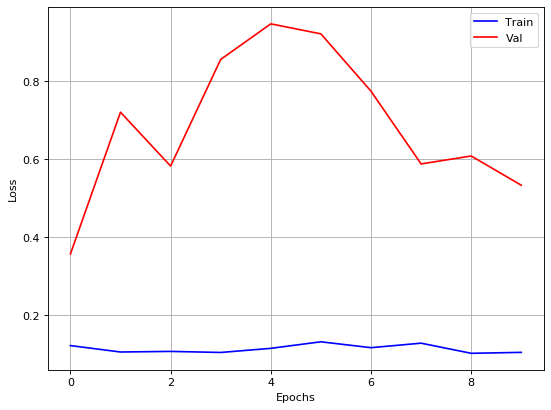

In [15]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.array(loss_values_train), 'b')
plt.plot(np.array(loss_values_val), 'r')
plt.legend(['Train','Val'])
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('fasttext/train_curve_feedback-v2_POS.png')
plt.show()

In [18]:
model = ConvNet(True, WINDOW=3)
print('Running on',device)
print('Building Master model..')
model.to(device)
print('Model Built.')

for i in range(10):
    FILE = 'fasttext/feedback-v2_POS/Model_quicksave'+str(i+1)+'.pt'

    model.load_state_dict(torch.load(FILE,map_location='cuda:0'))
    model.eval()

    corr = 0.0
    with torch.no_grad():
      for ib,sample in enumerate(test_loader):

        data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
        data_output = torch.as_tensor(sample['class'][:,0])

        data_input = data_input.to(device, dtype=torch.float)
        data_output = data_output.to(device, dtype=torch.long)

        output = model(data_input)
        _, preds = torch.max(output,dim=1)
        corr += (torch.sum(preds == data_output.data)).data.item()

    print('Test Accuracy : {:.2f}%'.format(corr*100.0/len(tset)))

Running on cuda:0
Building Master model..
Model Built.
Test Accuracy : 86.43%
Test Accuracy : 76.47%
Test Accuracy : 81.53%
Test Accuracy : 73.68%
Test Accuracy : 71.57%
Test Accuracy : 75.11%
Test Accuracy : 77.20%
Test Accuracy : 78.30%
Test Accuracy : 81.04%
Test Accuracy : 83.12%


In [29]:
LEARNINGRATE = 3e-5
GAMMA = 0.7

BATCHSIZE = 1024
NUMEPOCHS = 5


dset = CustomDataset.get_dataset('data/train.csv')
tset = CustomDataset.get_dataset('data/test.csv')

print('''
0 - World
1 - Sports
2 - Business
3 - Sci/Tech
''')

### TRAIN VAL SPLIT

NUM_DATA_POINTS = len(dset)

indices = list(range(NUM_DATA_POINTS))
split = int(np.floor(0.2 * NUM_DATA_POINTS))
np.random.shuffle(indices)

print(indices[0])


train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_points = len(train_indices)
val_points = len(val_indices)

train_loader = torch.utils.data.DataLoader(dset, batch_size = BATCHSIZE, 
                                           sampler=train_sampler, num_workers=4)
validation_loader = torch.utils.data.DataLoader(dset, batch_size = BATCHSIZE,
                                                sampler=valid_sampler, num_workers=4)
test_loader = torch.utils.data.DataLoader(tset, batch_size = BATCHSIZE,
                                                num_workers=4)

print("Printing Train + Val Number of Documents Found")
print(NUM_DATA_POINTS)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ConvNet(True, WINDOW=3)
print('Running on',device)
print('Building Master model..')
model.to(device)
print('Model Built.')

FILE = 'fasttext/weights_2/Model_quicksave5.pt'

model.load_state_dict(torch.load(FILE,map_location='cuda:0'))
model.eval()

print('Initializing optimizer and scheduler..')

criterion = torch.nn.NLLLoss()
optimizer = optim.RAdam(model.parameters(), lr = LEARNINGRATE)             # OR RAdam/DiffGrad/etc
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = GAMMA)

print('Optimizer and scheduler initialized.')


print('Printing Parameters')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
        #print(param.shape)
print('---Printing Parameters Finished!---')

corr = 0.0
with torch.no_grad():
  for ib,sample in enumerate(test_loader):

    data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
    data_output = torch.as_tensor(sample['class'][:,0])

    data_input = data_input.to(device, dtype=torch.float)
    data_output = data_output.to(device, dtype=torch.long)

    output = model(data_input)
    _, preds = torch.max(output,dim=1)
    corr += (torch.sum(preds == data_output.data)).data.item()

print('Test Accuracy : {:.2f}%'.format(corr*100.0/len(tset)))


from keras import backend as K
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Conv2D, Input, Dense, MaxPool2D, Flatten, Lambda, GlobalMaxPool2D, Dropout
from keras.models import Model
import tensorflow as tf
import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.utils.tests.networks import base as network_base

print(K.image_data_format())

with tf.device('/GPU:0'):
    inp = Input((None,300,1))
    x = Conv2D(1024,(3,300),activation='relu', name='conv1')(inp)
    x = GlobalMaxPool2D('channels_last')(x)
    x = Dense(256,name='fc1',activation='relu')(x)
    z = Dropout(0.25)(x)
    ou = Dense(32,name='fc2',activation='relu')(z)
    ou = Dropout(0.3)(ou)
    out = Dense(4,name='fc3')(ou)
    outz = Dropout(0.2)(out)
    k_model = Model(inp, outz)


trained_weights = model.state_dict()

pytorch_layers = [] # get ptroch layers names and suffixes
for x, l in zip(trained_weights, k_model.layers):
    pytorch_layers.append(x[:x.find('.')])

unique_layers = np.unique(pytorch_layers)
print(unique_layers)


for layer in unique_layers:
    weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
    biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
    if 'bn' in layer:
        running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
        running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
        W = [weights, biases, running_mean, running_var]
    elif 'fc' in layer:
        biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
        W = [weights.T, biases]
    else:
        W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
    k_model.get_layer(layer).set_weights(W)

k_model.summary()

method = ("lrp.z",{},"LRP-Z")
         
analyzer = innvestigate.create_analyzer(method[0], k_model,neuron_selection_mode="index",**method[1])



0 - World
1 - Sports
2 - Business
3 - Sci/Tech

14430
Printing Train + Val Number of Documents Found
120000
Running on cuda:0
Building Master model..
Model Built.
Initializing optimizer and scheduler..
Optimizer and scheduler initialized.
Printing Parameters
conv1.weight
conv1.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
---Printing Parameters Finished!---
Test Accuracy : 91.12%
channels_last
['conv1' 'fc1' 'fc2' 'fc3']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, None, 300, 1)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, 1, 1024)     922624    
_________________________________________________________________
global_max_pooling2d_8 (Glob (None, 1024)              0         
_________________________________________________________________
fc1 (Dense)                

In [30]:
import time

NUMEPOCHS = 5
top_n = 6
min_val_loss = float('inf')

loss_values_train = []
loss_values_val = []

print('Batch Size = ',BATCHSIZE)

for epoch in range(1,NUMEPOCHS+1):
    start_time = time.time()
    
    model.train()
    runloss = 0.0
    tacc = 0
    ##################
    #print('At start')
    #time.sleep(10)
    mode = 'Forced Epoch'

    for layer in unique_layers:
        weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
        biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
        if 'bn' in layer:
            running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
            running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
            W = [weights, biases, running_mean, running_var]
        elif 'fc' in layer:
            biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
            W = [weights.T, biases]
        else:
            W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
        k_model.get_layer(layer).set_weights(W)

    ############
    #print('After model load')
    #time.sleep(10)
    for ib,sample in enumerate(train_loader):

        data_input = sample['matrix'][:,None,:,:].numpy()
        data_output = sample['class'][:,0].numpy()

        for j in range(BATCHSIZE):
            #index = train_indices[BATCHSIZE*ib+j]
            #sample = dset[index]
            try:
                data = data_input[j]
            except IndexError as error:
                break

            data = data.reshape((1, -1, 300,1))    
            analysis = np.zeros(data.shape[1])

            a = np.squeeze(analyzer.analyze(data,neuron_selection=data_output[j]))
            a = np.sum(a, axis=1)

            order = np.argsort(a)[::-1]
            for k in order[top_n:]:
                data_input[j,:,k,:] = np.zeros((1,1,300)) 

        data_input = torch.as_tensor(data_input)
        data_output = torch.as_tensor(data_output)

        data_input = data_input.to(device, dtype=torch.float)  #, dtype=torch.float
        data_output = data_output.to(device, dtype=torch.long)    #, dtype=torch.long

        output = model(data_input) 
        _, preds = torch.max(output, 1)

        loss = criterion(output, data_output)
        runloss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        runloss += loss.item() * data_input.size(0)
        tacc += (torch.sum(preds == data_output.data)).data.item()

    runloss /= (train_points)
    tacc = tacc*100.0/ (train_points)

    loss_values_train.append(runloss)


    model.eval()

    val_loss = 0
    corr = 0
    
    with torch.no_grad():
        for ib,sample in enumerate(validation_loader):
            
            data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
            data_output = torch.as_tensor(sample['class'][:,0])

            data_input = data_input.to(device, dtype=torch.float)
            data_output = data_output.to(device, dtype=torch.long)

            output = model(data_input)
            _, preds = torch.max(output,dim=1)
            
            loss = criterion(output, data_output)
            val_loss += loss.item()* data_input.size(0)
            corr += (torch.sum(preds == data_output.data)).data.item()
            
    val_loss /= val_points
    corr = corr*100.0/val_points
    loss_values_val.append(val_loss)

    if val_loss <= min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'fasttext/feedback-v2_POS/Model_best_val_quicksave.pt')

    
    stop_time = time.time()
    time_el = int(stop_time-start_time)
    

    print('epoch [{}/{}] '.format(epoch, NUMEPOCHS)+mode+' loss:{:.7f}, train acc:{:.4f}, val loss:{:.7f}, val acc:{:.4f} in {}h {}m {}s'.format(
                                                                                runloss, tacc, val_loss, corr,
                                                                                time_el//3600,
                                                                                (time_el%3600)//60,
                                                                               time_el%60))
    
    torch.save(model.state_dict(), 'fasttext/feedback-v2_POS/Model_quicksave'+str(epoch)+'.pt')
    scheduler.step()
    

Batch Size =  1024
epoch [1/5] Forced Epoch loss:0.1348924, train acc:93.4510, val loss:0.1847103, val acc:93.9292 in 0h 4m 16s
epoch [2/5] Forced Epoch loss:0.1219127, train acc:93.7031, val loss:0.1862043, val acc:94.0500 in 0h 4m 14s
epoch [3/5] Forced Epoch loss:0.1113953, train acc:94.0719, val loss:0.1953512, val acc:93.9208 in 0h 4m 16s
epoch [4/5] Forced Epoch loss:0.1083174, train acc:94.0333, val loss:0.2047176, val acc:93.8167 in 0h 4m 15s
epoch [5/5] Forced Epoch loss:0.1075244, train acc:93.9542, val loss:0.2107031, val acc:93.7583 in 0h 4m 15s


In [31]:
model = ConvNet(True, WINDOW=3)
print('Running on',device)
print('Building Master model..')
model.to(device)
print('Model Built.')

for i in range(5):
    FILE = 'fasttext/feedback-v2_POS/Model_quicksave'+str(i+1)+'.pt'

    model.load_state_dict(torch.load(FILE,map_location='cuda:0'))
    model.eval()

    corr = 0.0
    with torch.no_grad():
      for ib,sample in enumerate(test_loader):

        data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
        data_output = torch.as_tensor(sample['class'][:,0])

        data_input = data_input.to(device, dtype=torch.float)
        data_output = data_output.to(device, dtype=torch.long)

        output = model(data_input)
        _, preds = torch.max(output,dim=1)
        corr += (torch.sum(preds == data_output.data)).data.item()

    print('Test Accuracy : {:.2f}%'.format(corr*100.0/len(tset)))

Running on cuda:0
Building Master model..
Model Built.
Test Accuracy : 91.67%
Test Accuracy : 92.01%
Test Accuracy : 91.91%
Test Accuracy : 91.78%
Test Accuracy : 91.71%
